
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [X] Make at least 1 partial dependence plot to explain your model.
- [X] Make at least 1 Shapley force plot to explain an individual prediction.
- [X] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

# Review from yesterday, i recommend using Ctrl+f and searching for @today

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv('../data/tribeca.csv')
df=df.drop('Unnamed: 0',axis=1)
df['LOG_PRICE']=np.log1p(df.SALE_PRICE)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,LOG_PRICE
0,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,222,1013,NaN,R4,"181 HUDSON STREET, 6D",6D,...,0.0,1.0,"7,878",1840.0,1909.0,2,R4,2800000,2019-01-03,14.845130
1,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,9022,NaN,R4,"10 LITTLE WEST STREET, 19A",19A,...,0.0,1.0,0,1759.0,0.0,2,R4,2650000,2019-01-07,14.790071
2,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,1441,NaN,R4,"30 LITTLE WEST STREET, 7G",7G,...,0.0,1.0,0,1190.0,2005.0,2,R4,1005000,2019-01-09,13.820499
3,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,3624,NaN,R4,"2 RIVER TERRACE, 4C",4C,...,0.0,1.0,0,1088.0,2006.0,2,R4,1678000,2019-01-10,14.333114
4,1,TRIBECA,13 CONDOS - ELEVATOR APARTMENTS,2,16,2610,NaN,R4,"380 RECTOR PLACE, 10A",10A,...,0.0,1.0,0,873.0,0.0,2,R4,1380000,2019-01-11,14.137595


In [3]:
# Going to get a list of the categorical variables an the numeric valiables and take a look at a baseline
# model
target = 'LOG_PRICE'

cat=df.select_dtypes(exclude='number')
num=df.select_dtypes(exclude='object')

# filter out unwanted features like dates
ignore=['ZIP_CODE','SALE_DATE','SALE_PRICE','LOG_PRICE']
cat=[x for x in cat if x not in ignore]
num=[x for x in num if x not in ignore]
features=cat+num

# validation split
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,random_state=42)
train,val=train_test_split(train,random_state=42)

# feature sets
X_train=train[features]
X_val=val[features]
X_test=test[features]

y_train=train[target]
y_val=val[target]
y_test=test[target]

print("(train shape)(val shape)(test shape)")
train.shape,val.shape,test.shape

(train shape)(val shape)(test shape)


((50, 22), (17, 22), (23, 22))

In [4]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    LinearRegression(n_jobs=-1)
)

pipeline.fit(X_train,y_train)
print("training r^2 is:",pipeline.score(X_train,y_train))
print("validation r^2 is:",pipeline.score(X_val,y_val))

training r^2 is: 0.797478474822824
validation r^2 is: 0.8652032879751262


In [5]:
import eli5
from eli5.sklearn import PermutationImportance
# make a transformation pipeline
autobot=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)
# make the transformed feature matrixs
X_train_encoded=autobot.fit_transform(X_train,y_train)
X_val_encoded=autobot.transform(X_val)

# fit the model with the transformed information
model=LinearRegression(n_jobs=-1)
model.fit(X_train_encoded,y_train)

# make a permutation importance finder
permuter=PermutationImportance(
    model,
    scoring=None,
    n_iter=5,
    random_state=42
)
# fit the premuter to the validation set
permuter.fit(X_val_encoded,y_val)

PermutationImportance(cv='prefit',
                      estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True, n_jobs=-1,
                                                 normalize=False),
                      n_iter=5, random_state=42, refit=True, scoring=None)

In [6]:
feature_names = X_val.columns.tolist()
# getting an error without poping an item of the list
feature_names.pop()
pd.Series(permuter.feature_importances_, feature_names).sort_values().index

Index(['LOT', 'NEIGHBORHOOD', 'COMMERCIAL_UNITS', 'RESIDENTIAL_UNITS',
       'EASE-MENT', 'BOROUGH', 'TAX_CLASS_AT_PRESENT', 'APARTMENT_NUMBER',
       'ADDRESS', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_CATEGORY',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'YEAR_BUILT', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'BLOCK', 'TOTAL_UNITS'],
      dtype='object')

In [7]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
1.0211 ± 0.7197,TOTAL_UNITS
0.0307 ± 0.0173,BLOCK
0.0142 ± 0.0200,GROSS_SQUARE_FEET
0.0141 ± 0.0124,LAND_SQUARE_FEET
0.0000 ± 0.0000,YEAR_BUILT
0.0000 ± 0.0000,BUILDING_CLASS_AT_TIME_OF_SALE
0.0000 ± 0.0000,BUILDING_CLASS_CATEGORY
0.0000 ± 0.0000,BUILDING_CLASS_AT_PRESENT
0.0000 ± 0.0000,ADDRESS
0.0000 ± 0.0000,APARTMENT_NUMBER


In [8]:
# Going to get a list of the categorical variables an the numeric valiables and take a look at a baseline
# model
target = 'LOG_PRICE'

cat=df.select_dtypes(exclude='number')
num=df.select_dtypes(exclude='object')

# filter out unwanted features like dates
ignore=['ZIP_CODE','SALE_DATE','SALE_PRICE','LOG_PRICE','LOT', 'NEIGHBORHOOD', 'COMMERCIAL_UNITS', 'RESIDENTIAL_UNITS',
       'EASE-MENT', 'BOROUGH', 'TAX_CLASS_AT_PRESENT', 'APARTMENT_NUMBER',
       'ADDRESS', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_CATEGORY',
       'BUILDING_CLASS_AT_TIME_OF_SALE']
cat=[x for x in cat if x not in ignore]
num=[x for x in num if x not in ignore]
features=cat+num

# validation split
from sklearn.model_selection import train_test_split
train,test=train_test_split(df,random_state=42)
train,val=train_test_split(train,random_state=42)

# feature setsa
X_train=train[features]
X_val=val[features]
X_test=test[features]

y_train=train[target]
y_val=val[target]
y_test=test[target]

print("(train shape)(val shape)(test shape)")
train.shape,val.shape,test.shape

(train shape)(val shape)(test shape)


((50, 22), (17, 22), (23, 22))

In [11]:
from xgboost import XGBRegressor


# end Review from yesterday @today

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['LAND_SQUARE_FEET'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'LAND_SQUARE_FEET',
                                          'data_type': dtype('O'),
                                          'mapping': 35,127    1
0         2
9,900     3
11,213    4
19,282    5
19,936    6
26,566    7
NaN      -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0))],
         verbose=False)

In [31]:
import pdb;
feature='TOTAL_UNITS'
from pdpbox.pdp import pdp_isolate,pdp_plot
from xgboost import XGBRFRegressor

pipeline=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBRegressor(n_jobs=-1)
)
pipeline.fit(X_train,y_train)
model=pipeline.named_steps['XGBRegressor'.lower()]

# make a transformation pipeline
autobot=make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median') # change this as needed
)
autobot.fit(X_train,y_train)

X_train_encoded=autobot.transform(X_train)
X_train_encoded_df=pd.DataFrame(data=X_train_encoded,columns=X_train.columns,index=X_train.index)
X_val_encoded=autobot.transform(X_val)

[18:41:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
#pdb.set_trace()
isolate=pdp_isolate(
    model=model,
    dataset=X_train_encoded,
    model_features=X_train.columns.to_list(),
    feature=feature
)


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5'] ['LAND_SQUARE_FEET', 'BLOCK', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE']
expected f3, f0, f5, f1, f2, f4 in input data
training data did not have the following fields: GROSS_SQUARE_FEET, TAX_CLASS_AT_TIME_OF_SALE, LAND_SQUARE_FEET, YEAR_BUILT, BLOCK, TOTAL_UNITS

In [14]:
print(X_train.columns.to_list())
print(X_train_encoded_df.columns.to_list())

['LAND_SQUARE_FEET', 'BLOCK', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE']
['LAND_SQUARE_FEET', 'BLOCK', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE']


In [15]:
print("X_train:\n",X_train.head(),"\nX_train_encoded_df:\n",X_train_encoded_df.head())

X_train:
    LAND_SQUARE_FEET  BLOCK  TOTAL_UNITS  GROSS_SQUARE_FEET  YEAR_BUILT  \
9            35,127    222          1.0             3227.0      1905.0   
72                0    220          1.0             3428.0         0.0   
64                0    190          1.0             2300.0         0.0   
1                 0     16          1.0             1759.0         0.0   
84                0     16          1.0              814.0         0.0   

    TAX_CLASS_AT_TIME_OF_SALE  
9                           2  
72                          2  
64                          2  
1                           2  
84                          2   
X_train_encoded_df:
     LAND_SQUARE_FEET  BLOCK  TOTAL_UNITS  GROSS_SQUARE_FEET  YEAR_BUILT  \
9                1.0  222.0          1.0             3227.0      1905.0   
72               2.0  220.0          1.0             3428.0         0.0   
64               2.0  190.0          1.0             2300.0         0.0   
1                2.0   16.0    

In [36]:
encoder=autobot.named_steps['ordinalencoder']
encoder.get_feature_names()
X_val_encoded=encoder.transform(X_val)
X_train_encoded=encoder.transform(X_train)

## I'm not sure what is going on with the above code, i've tested it and debugged it but i still don't know what is happing, I can't find anything online. 

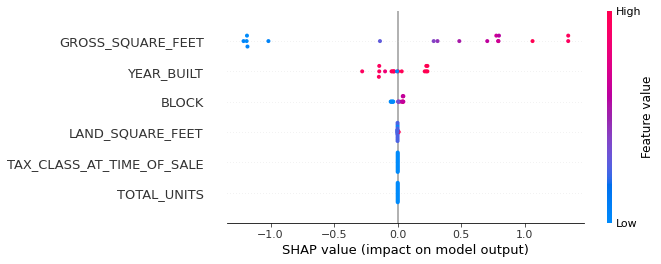

In [39]:
import shap
explainer=shap.TreeExplainer(model)
shap_values=explainer.shap_values(X_val_encoded)
shap.summary_plot(shap_values,X_val_encoded)

In [ ]:
test_score=pipeline.score(X_test,y_test)
print("testing score:",test_score)